In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
os.chdir('input')
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['.DS_Store', 'loan_theme_ids.csv', 'loan_themes_by_region.csv', 'kiva_loans.csv', 'kiva_mpi_region_locations.csv']


### Importing the required Libraries

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.utils import resample

from sklearn.ensemble.partial_dependence import plot_partial_dependence

from pydotplus import graph_from_dot_data

from io import StringIO
from IPython.display import Image

from pylab import rcParams

%matplotlib inline
rcParams['figure.figsize'] = 8, 4
sns.set_style('whitegrid')

### Reading the data

In [3]:
kiva_loans_df = pd.read_csv('../input/kiva_loans.csv')
loans_themes_df = pd.read_csv('../input/loan_themes_by_region.csv')
mpi_locations_df = pd.read_csv('../input/kiva_mpi_region_locations.csv')
loan_ids_df = pd.read_csv('../input/loan_theme_ids.csv')

### Overview of data

In [4]:
kiva_loans_df.sort_values('id').head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
35,653047,2225.0,2225.0,Personal Products Sales,Retail,to buy hair oils to sell.,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 04:49:26+00:00,2013-12-17 08:00:00+00:00,2014-01-19 16:39:37+00:00,11.0,58,"#Parent, #Repeat Borrower, user_favorite","female, female, female, female, female, female...",irregular,2014-01-01
9,653048,625.0,625.0,Food Production/Sales,Food,"to buy a stall, gram flour, ketchup, and coal ...",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 05:41:03+00:00,2013-12-17 08:00:00+00:00,2014-01-03 15:45:04+00:00,11.0,24,NaN,female,irregular,2014-01-01
43,653049,250.0,250.0,Shoe Sales,Retail,To buy women's shoes to sell,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 05:54:34+00:00,2013-12-17 08:00:00+00:00,2014-01-02 15:21:21+00:00,12.0,8,NaN,female,irregular,2014-01-01
22,653050,575.0,575.0,Clothing Sales,Clothing,To buy winter clothing to sell,PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:05:17+00:00,2013-12-17 08:00:00+00:00,2014-01-02 23:56:08+00:00,12.0,20,NaN,"female, female",irregular,2014-01-01
0,653051,300.0,300.0,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.0,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.0,12,NaN,female,irregular,2014-01-01


In [5]:
kiva_loans_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671205 entries, 0 to 671204
Data columns (total 20 columns):
id                    671205 non-null int64
funded_amount         671205 non-null float64
loan_amount           671205 non-null float64
activity              671205 non-null object
sector                671205 non-null object
use                   666973 non-null object
country_code          671197 non-null object
country               671205 non-null object
region                614405 non-null object
currency              671205 non-null object
partner_id            657698 non-null float64
posted_time           671205 non-null object
disbursed_time        668809 non-null object
funded_time           622874 non-null object
term_in_months        671205 non-null float64
lender_count          671205 non-null int64
tags                  499789 non-null object
borrower_genders      666984 non-null object
repayment_interval    671205 non-null object
date                  671205 non

In [6]:
loan_ids_df.head()

,id,Loan Theme ID,Loan Theme Type,Partner ID
0,638631,a1050000000skGl,General,151.0
1,640322,a1050000000skGl,General,151.0
2,641006,a1050000002X1ij,Higher Education,160.0
3,641019,a1050000002X1ij,Higher Education,160.0
4,641594,a1050000002VbsW,Subsistence Agriculture,336.0


In [9]:
loan_ids_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779092 entries, 0 to 779091
Data columns (total 4 columns):
id                 779092 non-null int64
Loan Theme ID      764279 non-null object
Loan Theme Type    764279 non-null object
Partner ID         764279 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 23.8+ MB


In [10]:
loans_themes_df.head()

,Partner ID,Field Partner Name,sector,Loan Theme ID,Loan Theme Type,country,forkiva,region,geocode_old,ISO,...,amount,LocationName,geocode,names,geo,lat,lon,mpi_region,mpi_geo,rural_pct
0,9,KREDIT Microfinance Institution,General Financial Inclusion,a1050000000slfi,Higher Education,Cambodia,No,Banteay Meanchey,"(13.75, 103.0)",KHM,...,450,"Banteay Meanchey, Cambodia","[(13.6672596, 102.8975098)]",Banteay Meanchey Province; Cambodia,"(13.6672596, 102.8975098)",13.667260,102.897510,"Banteay Mean Chey, Cambodia","(13.6672596, 102.8975098)",90.0
1,9,KREDIT Microfinance Institution,General Financial Inclusion,a10500000068jPe,Vulnerable Populations,Cambodia,No,Battambang Province,NaN,KHM,...,20275,"Battambang Province, Cambodia","[(13.0286971, 102.989615)]",Battambang Province; Cambodia,"(13.0286971, 102.989615)",13.028697,102.989615,"Banteay Mean Chey, Cambodia","(13.6672596, 102.8975098)",90.0
2,9,KREDIT Microfinance Institution,General Financial Inclusion,a1050000000slfi,Higher Education,Cambodia,No,Battambang Province,NaN,KHM,...,9150,"Battambang Province, Cambodia","[(13.0286971, 102.989615)]",Battambang Province; Cambodia,"(13.0286971, 102.989615)",13.028697,102.989615,"Banteay Mean Chey, Cambodia","(13.6672596, 102.8975098)",90.0
3,9,KREDIT Microfinance Institution,General Financial Inclusion,a10500000068jPe,Vulnerable Populations,Cambodia,No,Kampong Cham Province,"(12.0, 105.5)",KHM,...,604950,"Kampong Cham Province, Cambodia","[(12.0982918, 105.3131185)]",Kampong Cham Province; Cambodia,"(12.0982918, 105.3131185)",12.098292,105.313119,"Kampong Cham, Cambodia","(11.9924294, 105.4645408)",90.0
4,9,KREDIT Microfinance Institution,General Financial Inclusion,a1050000002X1Uu,Sanitation,Cambodia,No,Kampong Cham Province,"(12.0, 105.5)",KHM,...,275,"Kampong Cham Province, Cambodia","[(12.0982918, 105.3131185)]",Kampong Cham Province; Cambodia,"(12.0982918, 105.3131185)",12.098292,105.313119,"Kampong Cham, Cambodia","(11.9924294, 105.4645408)",90.0


In [11]:
loans_themes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15736 entries, 0 to 15735
Data columns (total 21 columns):
Partner ID            15736 non-null int64
Field Partner Name    15736 non-null object
sector                15736 non-null object
Loan Theme ID         15736 non-null object
Loan Theme Type       15736 non-null object
country               15736 non-null object
forkiva               15736 non-null object
region                15736 non-null object
geocode_old           1200 non-null object
ISO                   15722 non-null object
number                15736 non-null int64
amount                15736 non-null int64
LocationName          15736 non-null object
geocode               13662 non-null object
names                 13661 non-null object
geo                   15736 non-null object
lat                   13662 non-null float64
lon                   13662 non-null float64
mpi_region            15722 non-null object
mpi_geo               9671 non-null object
rural_pct     

In [12]:
mpi_locations_df.head()

,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.734772,70.811995
1,"Badghis, Afghanistan",AFG,Afghanistan,Badghis,South Asia,0.466,"(35.1671339, 63.7695384)",35.167134,63.769538
2,"Baghlan, Afghanistan",AFG,Afghanistan,Baghlan,South Asia,0.300,"(35.8042947, 69.2877535)",35.804295,69.287754
3,"Balkh, Afghanistan",AFG,Afghanistan,Balkh,South Asia,0.301,"(36.7550603, 66.8975372)",36.755060,66.897537
4,"Bamyan, Afghanistan",AFG,Afghanistan,Bamyan,South Asia,0.325,"(34.8100067, 67.8212104)",34.810007,67.821210


### Data Preparation: Cleaning and Manipulation

In [13]:
loans_df = (kiva_loans_df.drop(['use','country', 'currency', 
                                'date','posted_time','funded_time',
                                'disbursed_time'], axis=1)
            .set_index('id'))
loans_df.head()

,funded_amount,loan_amount,activity,sector,country_code,region,partner_id,term_in_months,lender_count,tags,borrower_genders,repayment_interval
id,,,,,,,,,,,,
653051,300.0,300.0,Fruits & Vegetables,Food,PK,Lahore,247.0,12.0,12,NaN,female,irregular
653053,575.0,575.0,Rickshaw,Transportation,PK,Lahore,247.0,11.0,14,NaN,"female, female",irregular
653068,150.0,150.0,Transportation,Transportation,IN,Maynaguri,334.0,43.0,6,"user_favorite, user_favorite",female,bullet
653063,200.0,200.0,Embroidery,Arts,PK,Lahore,247.0,11.0,8,NaN,female,irregular
653084,400.0,400.0,Milk Sales,Food,PK,Abdul Hakeem,245.0,14.0,16,NaN,female,monthly


In [14]:
loan_themes_merged = ((loan_ids_df.set_index(['Loan Theme ID']))
                      .join(loans_themes_df
                            .drop(['Loan Theme Type','geo','geocode_old', 'Field Partner Name', 
                                   'ISO', 'LocationName','geocode','names','lat','lon','mpi_region',
                                   'mpi_geo','country','sector','region','Partner ID'], axis=1)
                            .set_index(['Loan Theme ID']), how='left')
                      .set_index('id')
                     )
loan_themes_merged.head()

,Loan Theme Type,Partner ID,forkiva,number,amount,rural_pct
id,,,,,,
653129,Green,116.0,NaN,NaN,NaN,NaN
653132,Green,116.0,NaN,NaN,NaN,NaN
657412,Green,116.0,NaN,NaN,NaN,NaN
657904,Green,116.0,NaN,NaN,NaN,NaN
657926,Green,116.0,NaN,NaN,NaN,NaN


In [15]:
# loan_data_df = (loans_df.join(loan_themes_merged, how='left'))
loan_data_df = (loans_df.join(loan_ids_df.set_index('id'), how='left'))

loan_data_df.head()

,funded_amount,loan_amount,activity,sector,country_code,region,partner_id,term_in_months,lender_count,tags,borrower_genders,repayment_interval,Loan Theme ID,Loan Theme Type,Partner ID
id,,,,,,,,,,,,,,,
653051,300.0,300.0,Fruits & Vegetables,Food,PK,Lahore,247.0,12.0,12,NaN,female,irregular,NaN,NaN,NaN
653053,575.0,575.0,Rickshaw,Transportation,PK,Lahore,247.0,11.0,14,NaN,"female, female",irregular,a1050000000sjEC,Underserved,247.0
653068,150.0,150.0,Transportation,Transportation,IN,Maynaguri,334.0,43.0,6,"user_favorite, user_favorite",female,bullet,a1050000002VkWz,Underserved,334.0
653063,200.0,200.0,Embroidery,Arts,PK,Lahore,247.0,11.0,8,NaN,female,irregular,a1050000000sjEC,Underserved,247.0
653084,400.0,400.0,Milk Sales,Food,PK,Abdul Hakeem,245.0,14.0,16,NaN,female,monthly,a1050000000wf22,General,245.0


In [16]:
loan_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 671205 entries, 653051 to 1340339
Data columns (total 15 columns):
funded_amount         671205 non-null float64
loan_amount           671205 non-null float64
activity              671205 non-null object
sector                671205 non-null object
country_code          671197 non-null object
region                614405 non-null object
partner_id            657698 non-null float64
term_in_months        671205 non-null float64
lender_count          671205 non-null int64
tags                  499789 non-null object
borrower_genders      666984 non-null object
repayment_interval    671205 non-null object
Loan Theme ID         657692 non-null object
Loan Theme Type       657692 non-null object
Partner ID            657692 non-null float64
dtypes: float64(5), int64(1), object(9)
memory usage: 101.9+ MB


#### Missing values identification & cleaning

In [17]:
loan_data_df.country_code.fillna('-1', inplace=True)
loan_data_df.region.fillna('-1', inplace=True)
loan_data_df.partner_id.fillna(-1, inplace=True)
loan_data_df.tags.fillna('-1', inplace=True)
loan_data_df.borrower_genders.fillna('-1', inplace=True)
loan_data_df['Loan Theme ID'].fillna('-1', inplace=True)
loan_data_df['Loan Theme Type'].fillna('-1', inplace=True)
loan_data_df['Partner ID'].fillna('-1', inplace=True)
loan_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 671205 entries, 653051 to 1340339
Data columns (total 15 columns):
funded_amount         671205 non-null float64
loan_amount           671205 non-null float64
activity              671205 non-null object
sector                671205 non-null object
country_code          671205 non-null object
region                671205 non-null object
partner_id            671205 non-null float64
term_in_months        671205 non-null float64
lender_count          671205 non-null int64
tags                  671205 non-null object
borrower_genders      671205 non-null object
repayment_interval    671205 non-null object
Loan Theme ID         671205 non-null object
Loan Theme Type       671205 non-null object
Partner ID            671205 non-null object
dtypes: float64(4), int64(1), object(10)
memory usage: 101.9+ MB


In [18]:
loan_data_df['activity'] = loan_data_df['activity'].astype('category')
loan_data_df['sector'] = loan_data_df['sector'].astype('category')
loan_data_df['country_code'] = loan_data_df['country_code'].astype('category')
loan_data_df['region'] = loan_data_df['region'].astype('category')
loan_data_df['tags'] = loan_data_df['tags'].astype('category')
loan_data_df['borrower_genders'] = loan_data_df['borrower_genders'].astype('category')
loan_data_df['repayment_interval'] = loan_data_df['repayment_interval'].astype('category')
loan_data_df['Loan Theme ID'] = loan_data_df['Loan Theme ID'].astype('category')
loan_data_df['Loan Theme Type'] = loan_data_df['Loan Theme Type'].astype('category')
loan_data_df['Partner ID'] = loan_data_df['Partner ID'].astype('float')
loan_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 671205 entries, 653051 to 1340339
Data columns (total 15 columns):
funded_amount         671205 non-null float64
loan_amount           671205 non-null float64
activity              671205 non-null category
sector                671205 non-null category
country_code          671205 non-null category
region                671205 non-null category
partner_id            671205 non-null float64
term_in_months        671205 non-null float64
lender_count          671205 non-null int64
tags                  671205 non-null category
borrower_genders      671205 non-null category
repayment_interval    671205 non-null category
Loan Theme ID         671205 non-null category
Loan Theme Type       671205 non-null category
Partner ID            671205 non-null float64
dtypes: category(9), float64(5), int64(1)
memory usage: 71.1 MB


### Data Exploration

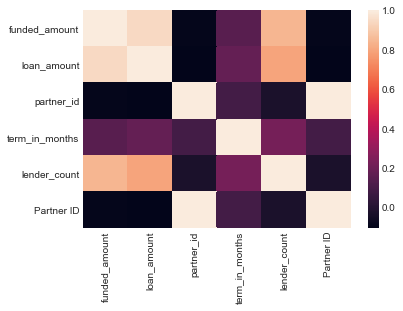

In [19]:
sns.heatmap(loan_data_df.corr())

In [20]:
loan_data_df.columns

Index(['funded_amount', 'loan_amount', 'activity', 'sector', 'country_code',
       'region', 'partner_id', 'term_in_months', 'lender_count', 'tags',
       'borrower_genders', 'repayment_interval', 'Loan Theme ID',
       'Loan Theme Type', 'Partner ID'],
      dtype='object')

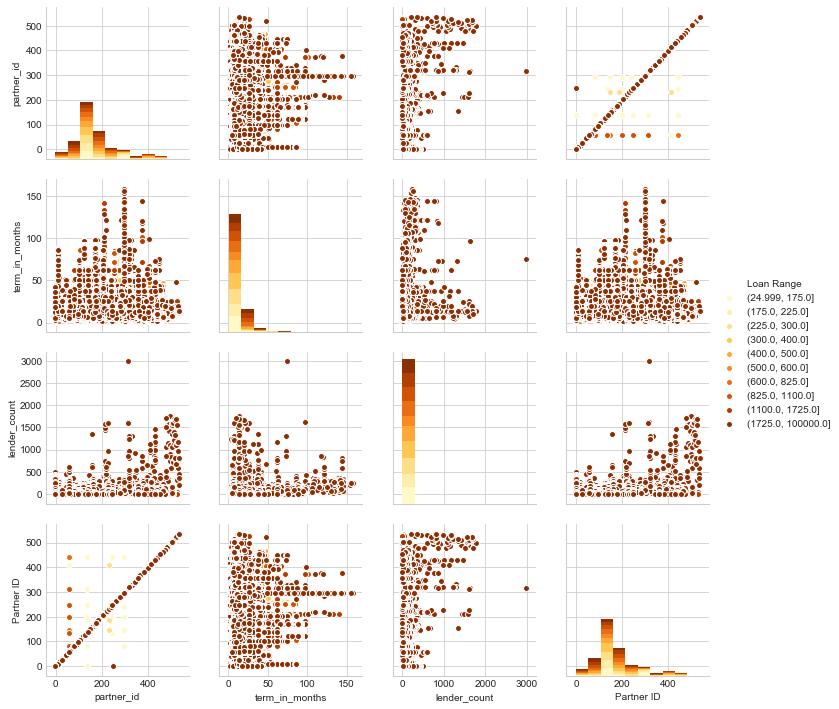

In [21]:
loan_data_df['Loan Range'] = pd.qcut(loan_data_df.loan_amount, 10)
g = sns.pairplot(loan_data_df.drop(['funded_amount','loan_amount'],axis=1), hue='Loan Range', palette="YlOrBr");

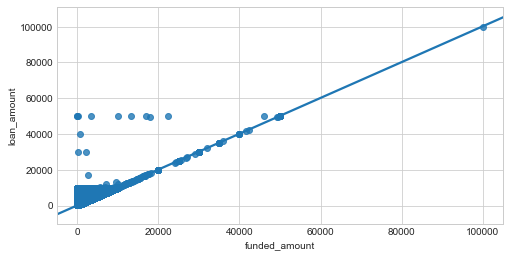

In [85]:
sns.regplot(x='funded_amount',y='loan_amount',data=loan_data_df);

In [90]:
loan_data_df['paid'] = loan_data_df.funded_amount.map(lambda x: True if x > 0 else False)

In [23]:
loan_data_df.columns

Index(['funded_amount', 'loan_amount', 'activity', 'sector', 'country_code',
       'region', 'partner_id', 'term_in_months', 'lender_count', 'tags',
       'borrower_genders', 'repayment_interval', 'Loan Theme ID',
       'Loan Theme Type', 'Partner ID', 'Loan Range'],
      dtype='object')

In [134]:
features = ['activity', 'sector', 'country_code',
       'region', 'partner_id', 'term_in_months', 'lender_count', 'tags',
       'borrower_genders', 'repayment_interval', 'Loan Theme ID',
       'Loan Theme Type', 'Partner ID']
paid_loans = loan_data_df.funded_amount != 0

In [150]:
X = loan_data_df.loc[:,features]

In [151]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 671205 entries, 653051 to 1340339
Data columns (total 13 columns):
activity              671205 non-null category
sector                671205 non-null category
country_code          671205 non-null category
region                671205 non-null category
partner_id            671205 non-null float64
term_in_months        671205 non-null float64
lender_count          671205 non-null int64
tags                  671205 non-null category
borrower_genders      671205 non-null category
repayment_interval    671205 non-null category
Loan Theme ID         671205 non-null category
Loan Theme Type       671205 non-null category
Partner ID            671205 non-null float64
dtypes: category(9), float64(3), int64(1)
memory usage: 60.8 MB


In [152]:
le = LabelEncoder()
le.fit(X['activity'])
X['activity'] = le.transform(X['activity'])
X['activity'] = X['activity'].astype('category')

le.fit(X['sector'])
X['sector'] = le.transform(X['sector'])
X['sector'] = X['sector'].astype('category')

le.fit(X['country_code'])
X['country_code'] = le.transform(X['country_code'])
X['country_code'] = X['country_code'].astype('category')

le.fit(X['region'])
X['region'] = le.transform(X['region'])
X['region'] = X['region'].astype('category')

le.fit(X['tags'])
X['tags'] = le.transform(X['tags'])
X['tags'] = X['tags'].astype('category')

le.fit(X['borrower_genders'])
X['borrower_genders'] = le.transform(X['borrower_genders'])
X['borrower_genders'] = X['borrower_genders'].astype('category')

le.fit(X['repayment_interval'])
X['repayment_interval'] = le.transform(X['repayment_interval'])
X['repayment_interval'] = X['repayment_interval'].astype('category')

le.fit(X['Loan Theme ID'])
X['Loan Theme ID'] = le.transform(X['Loan Theme ID'])
X['Loan Theme ID'] = X['Loan Theme ID'].astype('category')

le.fit(X['Loan Theme Type'])
X['Loan Theme Type'] = le.transform(X['Loan Theme Type'])
X['Loan Theme Type'] = X['Loan Theme Type'].astype('category')

In [154]:
y = loan_data_df.loc[:,'paid']

### Analysing top factors for loan approval

In [155]:
# Separate majority and minority classes
X_majority = X[y==1]
X_minority = X[y==0]
 
# Downsample majority class
X_majority_downsampled = resample(X_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(X_minority),     # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
X_downsampled = pd.concat([X_majority_downsampled, X_minority])

# Separate majority and minority classes
y_majority = y[y==1]
y_minority = y[y==0]
 
# Downsample majority class
y_majority_downsampled = resample(y_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=len(y_minority),     # to match minority class
                                 random_state=123) # reproducible results

# Combine minority class with downsampled majority class
y_downsampled = pd.concat([y_majority_downsampled, y_minority])


# Display new class counts
y_downsampled.value_counts()

True     3383
False    3383
Name: paid, dtype: int64

Training data score 0.9880873593646592
Validation data score 0.9641737572772056


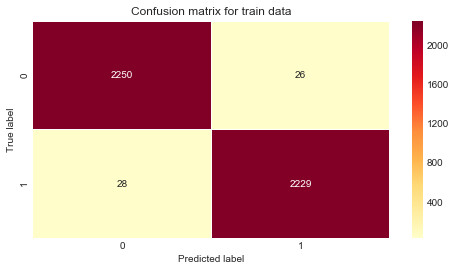

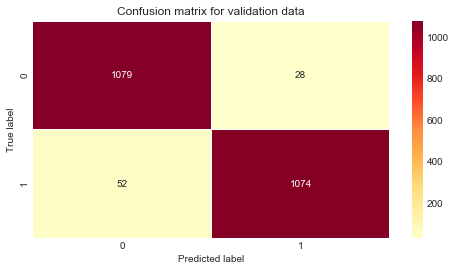

In [198]:
clf = RandomForestClassifier(n_estimators=1, 
                             random_state=1,
#                              oob_score=True, 
                             n_jobs=-1
#                             , class_weight='balanced'
                            )

X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_downsampled, test_size=0.33, random_state=42)
clf.fit(X_train,y_train)

# print (clf.oob_score_)

print ("Training data score", clf.score(X_train, y_train))

y_pred = clf.predict(X_train)
cfm = confusion_matrix(y_train, y_pred)
plt.figure()
sns.heatmap(cfm, annot=True, fmt="d", linewidths=.5, center=cfm.mean(), cmap="YlOrRd");
plt.title('Confusion matrix for train data')
plt.ylabel('True label')
plt.xlabel('Predicted label')

print ("Validation data score", clf.score(X_test, y_test))

y_pred = clf.predict(X_test)
cfm = confusion_matrix(y_test, y_pred)
plt.figure()
sns.heatmap(cfm, annot=True, fmt="d", linewidths=.5, center=cfm.mean(), cmap="YlOrRd");
plt.title('Confusion matrix for validation data')
plt.ylabel('True label')
plt.xlabel('Predicted label');

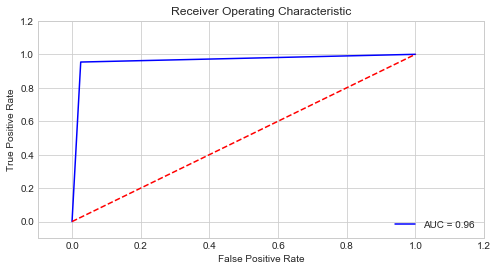

In [187]:
fpr = dict()
tpr = dict()
roc_auc = dict()
    
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

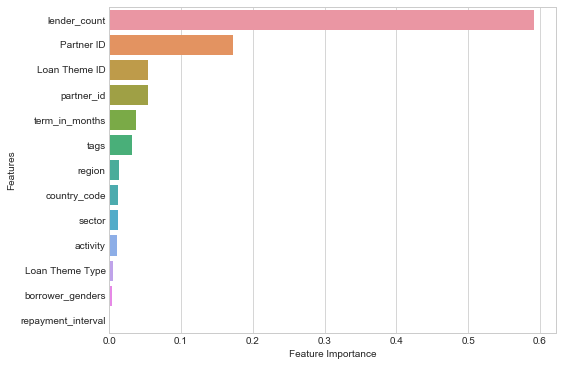

In [188]:
plt.figure(figsize=[8,6])
feature_imp = pd.DataFrame({'Feature Importance' : clf.feature_importances_, 'Features' : X.columns})
feature_imp.sort_values(by='Feature Importance', inplace=True, ascending=False)
impplot = sns.barplot(x='Feature Importance', y = 'Features', data=feature_imp)

### Loan Approval Conclusion
Number of lenders contributing to loan is by far the most important factor for a loan to be approved.

In [153]:
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)
print ('Explained Variance Ratio = ', pca.explained_variance_ratio_)

Explained Variance Ratio =  [0.95329855 0.02776673]


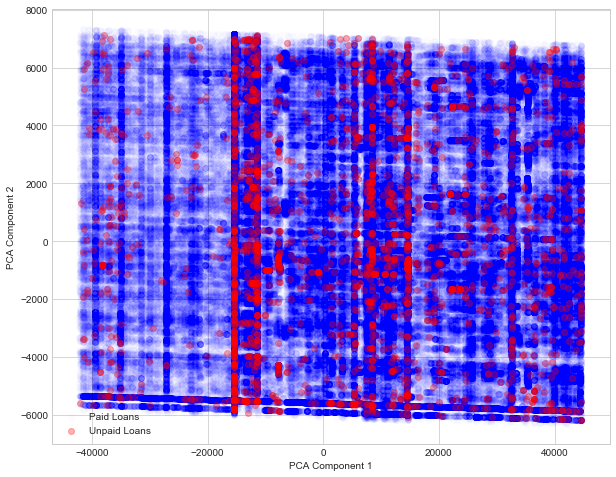

In [189]:
plt.figure(figsize=[10,8])
ax = sns.regplot(x=X_pca[y==1,0],y=X_pca[y==1,1],fit_reg=False, 
            scatter_kws={"alpha": .01}, color='blue', label='Paid Loans')
ax = sns.regplot(x=X_pca[y==0,0],y=X_pca[y==0,1],fit_reg=False, ax= ax,
            scatter_kws={"alpha": .3}, color='red', label='Unpaid Loans')
plt.legend();
plt.ylabel('PCA Component 2');
plt.xlabel('PCA Component 1');

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# clf.fit(X_pca,y)
# xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
#                      np.linspace(*ylim, num=200))
# Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# Create a color plot with the results
# n_classes = len(np.unique(y))
# contours = ax.contourf(xx, yy, Z, alpha=0.3,
#                        levels=np.arange(n_classes + 1) - 0.5,
#                        cmap=plt.cm.Reds,
#                        zorder=1)

### Modeling the appreoved loan amount and finding the most important features

In [206]:
X = X.loc[paid_loans,:]
y = loan_data_df.loc[paid_loans,'funded_amount']

In [207]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [208]:
regr = RandomForestRegressor(n_jobs=-1)
regr.fit(X_train,y_train)
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

In [212]:
print('Traingin data score :', regr.score(X_train, y_train))

Traingin data score : 0.9810971459414434


In [211]:
print('Validation data score :', regr.score(X_test, y_test))

Validation data score : 0.894131815614719


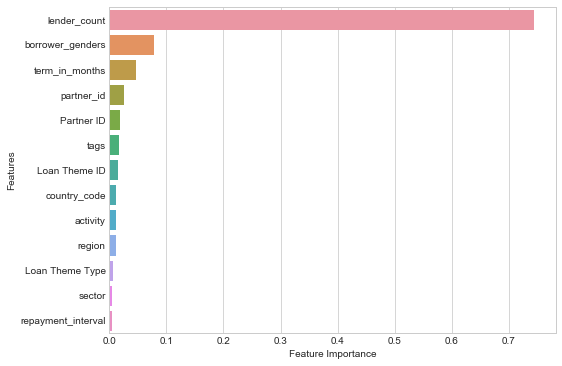

In [213]:
plt.figure(figsize=[8,6])
feature_imp = pd.DataFrame({'Feature Importance' : regr.feature_importances_, 'Features' : X.columns})
feature_imp.sort_values(by='Feature Importance', inplace=True, ascending=False)
impplot = sns.barplot(x='Feature Importance', y = 'Features', data=feature_imp)
# regr.feature_importances_

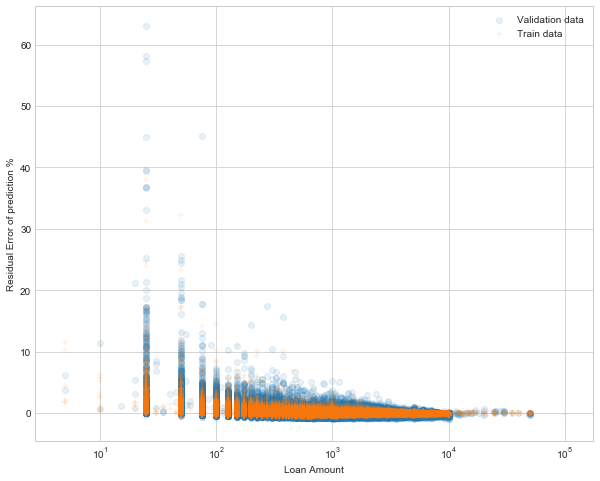

In [220]:
plt.figure(figsize=[10,8])
sns.regplot(y_test, (y_test_pred - y_test)/y_test, fit_reg=False, 
            scatter_kws={"alpha": .1}, label='Validation data', marker='o');
plt.xscale('log')
sns.regplot(y_train, (y_train_pred - y_train)/y_train, fit_reg=False, 
            scatter_kws={"alpha": .1}, label='Train data', marker='+');
plt.legend();
plt.xlabel('Loan Amount');
plt.ylabel('Residual Error of prediction (%)');

### Loan amount prediction conclusion:
- Number of lenders contributing to loan and gender of the borrowere are the most important factors for determining the amount of loan to be approved.
- Our model has higher accuracy for larger loans